In [1]:
from imports import *
from utils import process_file

In [39]:
warnings.filterwarnings("ignore")

### **Ajuste de modelos** 

* A partir de las transformaciones propuestas ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.
* Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones usando SARIMA y extraer conclusiones.
* Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacional usando la descomposición.

#### Cargamos dataset ya preprocesado

In [2]:
bicis_data = process_file()

In [6]:
type(bicis_data)

pandas.core.series.Series

#### Fiteamos un MA(7)
El valor 7 lo elegimos a partir de observar los graficos de acf y pacf en notebook de EDA

In [7]:
order = 7
ma_model = ARIMA(bicis_data, order=(0, 0, order)).fit()
#ma_model.summary()

#### Fiteamos un AR(7)
El valor 7 lo elegimos a partir de observar los graficos de acf y pacf

In [8]:
lag_order = 7
ar_model = AutoReg(bicis_data, lags=lag_order).fit()
#ar_model.summary()

In [9]:
def plot_error(model, model_name):
    err_raw = model.predict() - bicis_data
    plt.violinplot([err_raw.dropna(), bicis_data.dropna()])
    plt.title(model_name)
    plt.grid()

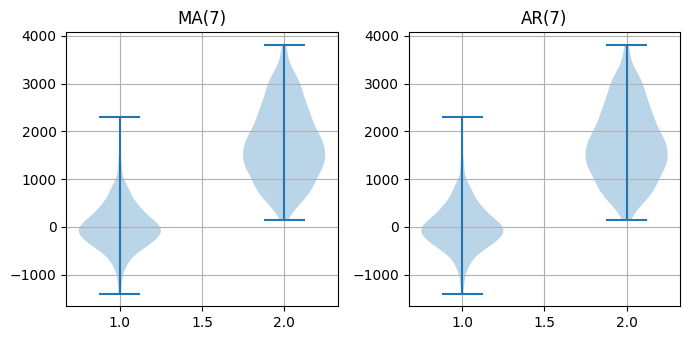

In [27]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_error(ar_model, "MA(7)")
plt.subplot(1, 2, 2)
plot_error(ar_model, "AR(7)")
plt.tight_layout()
plt.show()

In [35]:
def plot_relative_error(model, model_name):
    #Para calcular el error relativo, eliminamos los ceros que corresponden a 13 datapoints
    mask = bicis_data > 0
    err_raw = model.predict() - bicis_data
    percentiles = np.percentile((err_raw[mask] / bicis_data[mask]).dropna(), [25,50,75])
    print("percentiles:", f'{model_name}', percentiles)
    plt.violinplot((err_raw[mask] / bicis_data[mask]).dropna(), points=300)
    plt.hlines(percentiles, 0.7, 1.3, color='k', linestyle='--')
    plt.ylim(-2,3)
    plt.title(model_name)
    plt.grid()
    

percentiles: Error relativo: AR(7) [-0.13584936 -0.0228191   0.21956661]
percentiles: Error relativo: MA(7) [-0.14561456 -0.00641774  0.31278894]


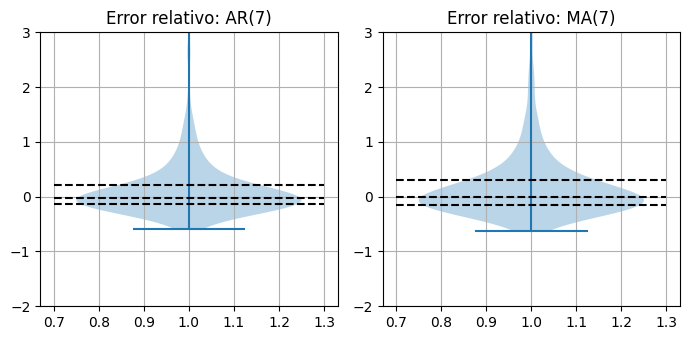

In [36]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_relative_error(ar_model, "Error relativo: AR(7)")
plt.subplot(1, 2, 2)
plot_relative_error(ma_model, "Error relativo: MA(7)")
plt.tight_layout()
plt.show()

##### **Observacion**

* La mediana del error del **modelo autoregresivo** esta en -0.022, lo que significa que el **50%** de las veces predice alrededor de 2.2% menos que la data real.  El **25%** de las veces predice por defecto por lo menos un 13% menos que la data real.
En el extremo superior, en el percentil **75** ,predice por exceso al menos un 21% mas que la data real.

* La mediana del error del **modelo moving average** esta en -0.006, lo que significa que el **50%** de las veces predice alrededor de 0.6% menos que la data real.  El **25%** de las veces predice por defecto por lo menos un 14% menos que la data real.
En el extremo superior, en el percentil **75** ,predice por exceso al menos un 31% mas que la data real.
 


#### Fiteamos un ARIMA(7,1,7)

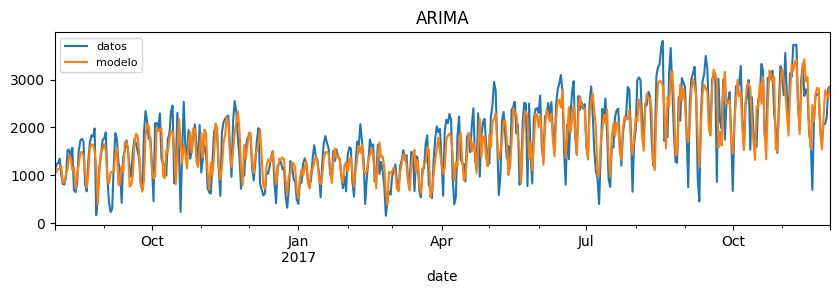

time to fit:  1.41 seg


In [45]:
def plotARMA(series,ax):
    mod = sm.tsa.ARIMA(series, order=(7,1,7), missing='raise').fit()
    series.plot(ax=ax,label="datos")
    mod.predict()[1:].plot(ax=ax,label="modelo")
    return mod

fig,ax = plt.subplots(figsize=(10,2.5))    
t0 = time()
arima = plotARMA(bicis_data,ax)
arima_time = time() - t0

plt.legend(fontsize=8)
plt.title("ARIMA")
plt.show()

arima_time_rounded = round(arima_time, 2)
print("time to fit: ", arima_time_rounded, "seg")

percentiles: Error relativo ARIMA [-0.15565632 -0.04481075  0.12405158]


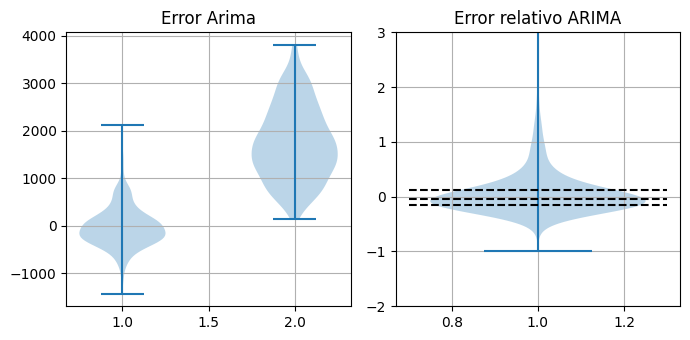

In [47]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plot_error(arima, "Error Arima")
plt.subplot(1, 2, 2)
plot_relative_error(arima, "Error relativo ARIMA")
plt.tight_layout()
plt.show()

### ARIMA FORECAST

#### 1. Split into train and test sets

In [49]:
X = bicis_data
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]

#### 2. **Simple forecast model**: 
Fit on train, forecast on test

In [66]:
def arima_forecast(train, test, order=(7, 1, 7)):
    arima_forecast = ARIMA(train, order=order).fit()
    
    # Forecast
    predictions = arima_forecast.forecast(steps=len(test))
    predictions_values = predictions.values
    test_values = test.values
    
    # Calculamos rmse
    rmse = sqrt(mean_squared_error(test_values, predictions_values))
    print('Test RMSE: %.3f' % rmse)
    
    # Plot predictions vs actual values
    plt.figure(figsize=(8,2.5))
    plt.plot(test_values, label='Test')
    plt.plot(predictions_values, color='red', label='Predictions')
    plt.title("Arima Forecast")
    plt.legend()
    plt.show()

Test RMSE: 604.401


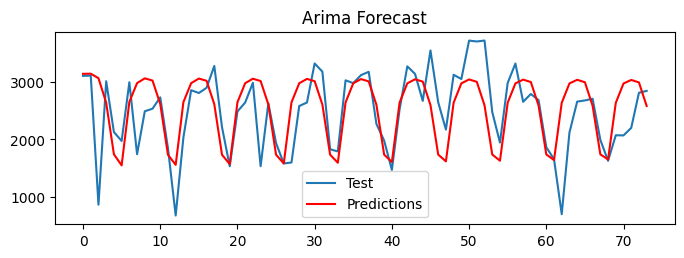

time to fit:  1.71 seg


In [67]:
t0 = time()
arima_forecast(train, test)
arima_forecast_time = time() - t0

arima_forecast_time = round(arima_forecast_time, 2)
print("time to fit: ", arima_forecast_time, "seg")

#### 3. **Rolling forecast model**: 
Actualizamos de manera iterativa el train set con los valores observados en el test set y volvemos a fitear el modelo para predecir para los siguientes time steps.

In [68]:
def arima_rolling_forecast(train, test, order=(7, 1, 7)):
    # Guardamos training history
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):
        # fiteamos arima
        arima_rolling_forecast = ARIMA(history, order=order).fit()
        
        # Forecast one step ahead
        output = arima_rolling_forecast.forecast()
        yhat = output[0]
        predictions.append(yhat)
        
        # actualizamos history con los valores observados del test set
        obs = test[t]
        history.append(obs)
    
    # RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    
    plt.figure(figsize=(8,2.5))
    plt.plot(test.values, label='Test')
    plt.plot(predictions, color='red', label='Predictions')
    plt.legend()
    plt.show()


Test RMSE: 606.121


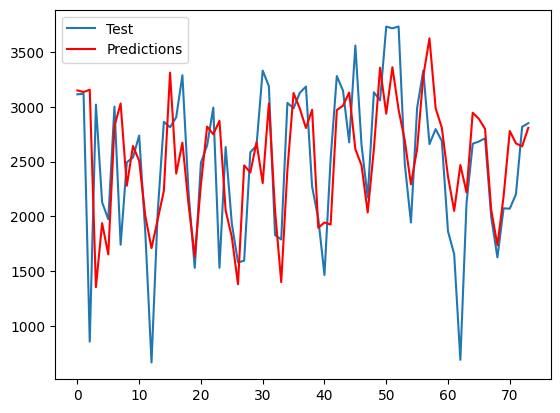

time to fit:  90.49 seg


In [70]:
t0 = time()
arima_rolling_forecast(train, test)
arima_rolling_forecast_time = time() - t0

arima_rolling_forecast_time = round(arima_rolling_forecast_time, 2)
print("time to fit: ", arima_rolling_forecast_time, "seg")

#### Observaciones

1. Dividimos la serie en train y test. Fiteamos en train y predecimos en test.
2. Primero probamos con un modelo arima normal con parametros AR=7, I=1 y MA=7. El root mean squared error en Test es **604.401** y demora **1.71 seg** en entrenar.
3. Probamos un rolling forecast model, esto es actualizamos de manera iterativa el train set con los valores observados en el test set y volvemos a fitear el modelo para predecir para los siguientes time steps. El root mean squared error en Test es **606.121** y demora **90.49 seg**

Conclusion: el primer modelo que es mas simple es mejor. 


###  Fiteamos un SARIMA order=(7,1,7), seasonal_order=(4,1,4,28)
seasonal order 4 = 4 meses, s = 28 porque cada ciclo tiene 28 dias 

##### SARIMA order parameters
* p = ??  # Autoregressive order
* d = ??  # Differencing order
* q = ??  # Moving average order
* P = ??  # Seasonal autoregressive order
* D = ??  # Seasonal differencing order
* Q = ??  # Seasonal moving average order
* s = ??  # Seasonal period

In [71]:
def sarima_forecast(train, test, order=(7, 1, 7), seasonal_order=(4,1,4,28)):
    sarima_forecast = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order, missing='raise').fit()
    
    # Forecast
    predictions = sarima_forecast.forecast(steps=len(test))
    predictions_values = predictions.values
    test_values = test.values
    
    # Calculamos rmse
    rmse = sqrt(mean_squared_error(test_values, predictions_values))
    print('Test RMSE: %.3f' % rmse)
    
    # Plot predictions vs actual values
    plt.figure(figsize=(8,2.5))
    plt.plot(test_values, label='Test')
    plt.plot(predictions_values, color='red', label='Predictions')
    plt.title("Sarima Forecast")
    plt.legend()
    plt.show()

In [ ]:
t0 = time()
sarima_forecast(train, test)
sarima_forecast_time = time() - t0

sarima_forecast_time = round(sarima_forecast_time, 2)
print("time to fit: ", sarima_forecast_time, "seg")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10895D+00    |proj g|=  1.81613D-01


In [ ]:


def plotSARIMA(series,ax):
    mod = sm.tsa.SARIMAX(series, order=(7,1,7), seasonal_order=(4,1,4,28),  missing='raise').fit()
    series.plot(ax=ax,label="datos")
    mod.predict()[1:].plot(ax=ax,label="modelo")
    return mod

fig,ax = plt.subplots(figsize=(10,3))    
t0 = time()

sarima = plotSARIMA(bicis_por_dia_trimmed,ax)
sarima_time = time() - t0

plt.legend(fontsize=8)
plt.title("SARIMA")
plt.show()

sarima_time